<a href="https://www.kaggle.com/code/joostyoshi/glassbox-on-all-datasets?scriptVersionId=185784474" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
!pip install interpret

^C
ERROR: Operation cancelled by user


In [3]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, roc_curve
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from interpret import show
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE',''):
    os.chdir('/kaggle/input/data-cusser')

In [5]:
def mergeDF(file1,file2,on=["Path"]):
    #Merging two dataframes utility function
    df = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    df3 = df.merge(df2, how="left",on=on)
    print(df3.head())
    return df3

In [6]:

def plot_feature_scores_across_datasets(datasets, dataset_labels, colors, model_name, figsize=(15, 20), bar_height=0.3):
    """
    Plots sorted feature scores across multiple datasets, indicating the model used.

    Parameters:
    - datasets: List of dictionaries, where each dictionary contains 'names' and 'scores'
    - dataset_labels: List of labels for the datasets (e.g., ['CREMA-D', 'BEASC', 'Emo-DB'])
    - colors: List of colors for each dataset
    - model_name: Name of the model to display in the title
    - figsize: Tuple for the figure size
    - bar_height: Height of the horizontal bars in the plot
    """
    # Create DataFrames for each dataset and calculate combined feature list
    dfs = [pd.DataFrame(data).set_index('names') for data in datasets]
    all_features = sorted(set.union(*(set(df.index) for df in dfs)))

    # Reindex and fill missing entries with 0
    for i in range(len(dfs)):
        dfs[i] = dfs[i].reindex(all_features, fill_value=0).reset_index()

    # Calculate total importance of each feature across all datasets
    total_scores = sum(df['scores'] for df in dfs)

    # Create a DataFrame for sorting features by total importance
    feature_importance = pd.DataFrame({'features': all_features, 'total_scores': total_scores})
    feature_importance = feature_importance.sort_values(by='total_scores', ascending=True)

    # Sort each dataset based on the sorted features
    sorted_features = feature_importance['features'].tolist()
    for i in range(len(dfs)):
        dfs[i] = dfs[i].set_index('names').reindex(sorted_features).reset_index()

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)
    indices = np.arange(len(sorted_features))

    # Initialize the left alignment for stacked bars
    lefts = np.zeros(len(sorted_features))

    for i, df in enumerate(dfs):
        ax.barh(indices, df['scores'], bar_height, label=dataset_labels[i], color=colors[i], left=lefts)
        lefts += df['scores'].values  # Update lefts for the next stack

    ax.set_ylabel('Features')
    ax.set_xlabel('Scores')
    ax.set_title(f'Sorted Feature Scores for {model_name}')
    ax.set_yticks(indices)
    ax.set_yticklabels(sorted_features)
    ax.legend()
    plt.savefig(f'/kaggle/working/Sorted Feature Scores for {model_name}', bbox_inches="tight")
    plt.show()
    

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_top_feature_scores(datasets, dataset_labels, colors, model_name, figsize=(20, 6), bar_height=0.4):
    """
    Plots sorted top 10 feature scores across multiple datasets, indicating the model used.
    Features are split into two categories:
    - 5 with similar scores
    - 5 with diverse scores but present in all datasets
    """
    # Create DataFrames for each dataset and calculate combined feature list
    dfs = [pd.DataFrame(data).set_index('names') for data in datasets]
    all_features = sorted(set.intersection(*(set(df.index) for df in dfs)))
    
    # Keep only features present in all datasets
    for i in range(len(dfs)):
        dfs[i] = dfs[i].loc[all_features].reset_index()

    # Calculate total importance and variance of each feature across all datasets
    total_scores = np.sum([df['scores'].values for df in dfs], axis=0)
    score_variances = np.nanvar([df['scores'].values for df in dfs], axis=0)

    # Create a DataFrame for sorting features by total importance and variance
    feature_stats = pd.DataFrame({
        'features': all_features,
        'total_scores': total_scores,
        'score_variance': score_variances
    })

    # Select top 10 features, then split based on variance
    similar_scores = feature_stats.sort_values(by='score_variance').head(5)
    diverse_scores = feature_stats.sort_values(by='score_variance').tail(5)

    # Ensure selected features are present in all datasets
    similar_scores = similar_scores[similar_scores['features'].isin(all_features)]
    diverse_scores = diverse_scores[diverse_scores['features'].isin(all_features)]

    # Plotting setup for two side-by-side plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    # Plotting similar scores
    plot_features(similar_scores, dfs, dataset_labels, colors, model_name, 'Top 5 Features with Similar Scores', axes[0], bar_height)
    
    # Plotting diverse scores
    plot_features(diverse_scores, dfs, dataset_labels, colors, model_name, 'Top 5 Features with Diverse Scores', axes[1], bar_height)

    plt.tight_layout(pad=2.0)
    plt.savefig(f'/kaggle/working/{model_name}', bbox_inches="tight")
    plt.show()

def plot_features(selected_features, dfs, dataset_labels, colors, model_name, plot_title, ax, bar_height):
    """
    Helper function to plot selected features on a specific subplot ax.
    """
    # Sort each dataset based on the selected features and ensure features with highest total scores are at top
    sorted_features = selected_features.sort_values(by='total_scores', ascending=False)['features'].tolist()
    filtered_dfs = []
    for df in dfs:
        filtered_df = df[df['names'].isin(sorted_features)].set_index('names').reindex(sorted_features).reset_index()
        filtered_dfs.append(filtered_df)

    indices = np.arange(len(sorted_features))

    # Initialize the left alignment for stacked bars
    lefts = np.zeros(len(sorted_features))

    for i, df in enumerate(filtered_dfs):
        ax.barh(indices, df['scores'], bar_height, label=dataset_labels[i], color=colors[i], left=lefts)
        lefts += df['scores'].values  # Update lefts for the next stack

    ax.set_ylabel('Features')
    ax.set_xlabel('Scores')
    ax.set_title(f'{plot_title} for {model_name}')
    ax.set_yticks(indices)
    ax.invert_yaxis()  # Most contributed on top
    ax.set_yticklabels(sorted_features)
    ax.legend()



In [8]:
def createGlassbox(file,excludeCols=['path'],splits_exist =False, split_prefix="", label_col="emotion"):
    if isinstance(file, str):
        df = pd.read_csv(file, index_col=False)
    else:
        df = file

    df.reset_index(drop=True, inplace=True)
    df = df.drop(columns=excludeCols)
    unique_subjects = df['ActorID'].unique()

    if(splits_exist):
        val_df=pd.read_csv(split_prefix+"_test_df.csv")
        purt_df=pd.read_csv(split_prefix+"_val_df.csv")
        train_df=pd.read_csv(split_prefix+"_train_df.csv")
        train_subjects=train_df["ActorID"].unique()
        val1 = purt_df["ActorID"].unique()
        val2 = val_df["ActorID"].unique()
        temp_subject = val1 + val2
    train_subjects, temp_subjects = train_test_split(unique_subjects, test_size=0.3, random_state=42)

    # Step 3: Create DataFrames for each split based on the subject IDs
    train_df = df[df['ActorID'].isin(train_subjects)]
    test_df = df[df['ActorID'].isin(temp_subjects)]

    x_train = train_df.drop(columns=[label_col, 'ActorID'])
    y_train = train_df[label_col]
    x_test = test_df.drop(columns=[label_col, 'ActorID'])
    y_test = test_df[label_col]

    ebm = ExplainableBoostingClassifier()
    ebm.fit(x_train, y_train)

    return ebm, x_test, y_test, test_df['ActorID']


In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_roc_curve(ebm, x_test, y_test):
    classes = ebm.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    y_score = ebm.decision_function(x_test)
    
    fpr, tpr, roc_auc = {}, {}, {}
    for i, label in enumerate(classes):
        fpr[label], tpr[label], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])
    
    plt.figure(figsize=(10, 8))
    for label in classes:
        plt.plot(fpr[label], tpr[label], label=f'{label} (area = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for each Emotion')
    plt.legend(loc="lower right")
    plt.show()


In [10]:
def get_local_explanations_angry(ebm, x_test, y_test):
    # Predict labels for the test set
    y_pred = ebm.predict(x_test)

    # Filter for instances where predicted label is 'angry'
    angry_indices = (y_pred == 'angry')
    angry_x_test = x_test[angry_indices]
    angry_y_test = y_test[angry_indices]

    # Store local explanations
    local_explanations = []
    explanation_data = []

    # Iterate over each 'angry' instance to get local explanations
    for index, row in angry_x_test.iterrows():
        # Get local explanation for the specific instance
        local_explanation = ebm.explain_local(row.to_frame().transpose(), angry_y_test.loc[index])
        local_explanations.append(local_explanation)
        
        # Access and store the raw explanation data for all visualizations
        explanation_details = local_explanation.data(-1)
        explanation_data.append(explanation_details)

    return local_explanations, explanation_data

In [11]:
from interpret import show

def display_global_explanation(ebm):
    global_explanation = ebm.explain_global()
    show(global_explanation)
    return global_explanation.data()

<h2>CREMA EBMs</h2>


In [13]:
crema_ebm, crema_x_test, crema_y_test, crema_test_df = createGlassbox("data/opensmileDF_crema.csv",  excludeCols = ["path","Unnamed: 0"],splits_exist =True, split_prefix="data/crema")

/opt/conda/lib/python3.10/site-packages/interpret/glassbox/_ebm/_ebm.py:999: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


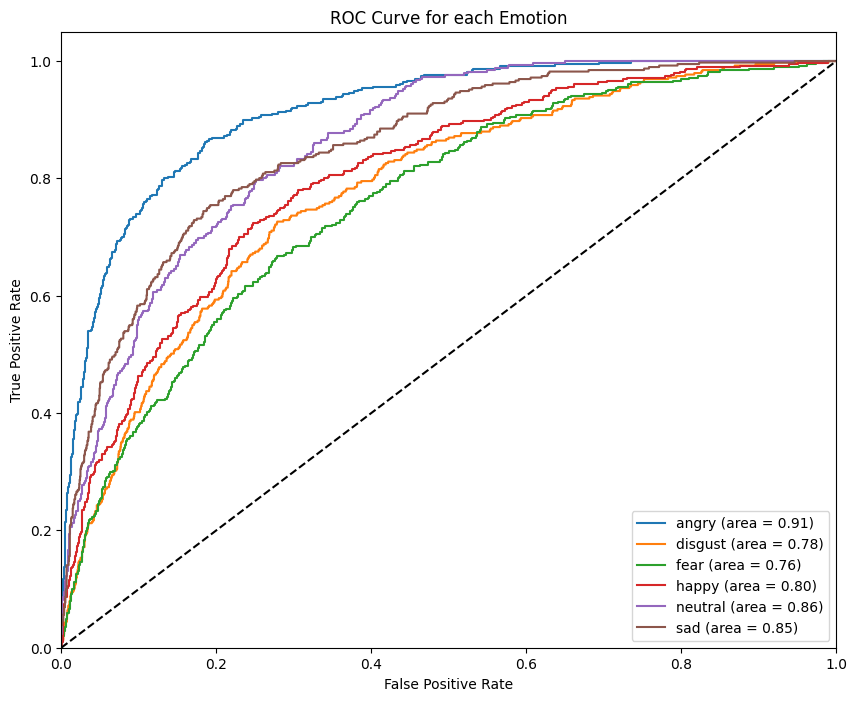

In [14]:
plot_roc_curve(crema_ebm, crema_x_test, crema_y_test)

In [15]:
crema_local_explanations, crema_explanation_data = get_local_explanations_angry(crema_ebm, crema_x_test, crema_y_test)
show(crema_local_explanations[0])

In [ ]:
show()

In [ ]:
toExclude = ["path"]
crema_avd_data = createGlassbox("data/crema_avd.csv",  excludeCols = toExclude, splits_exist =True, split_prefix="data/crema")

In [ ]:
toExclude = ["path","Age","Sex","Race","Ethnicity"]
crema_opensmile_avd_data = createGlassbox("data/crema_opensmile_avd.csv",  excludeCols = toExclude,splits_exist =True, split_prefix="data/crema")

<h2>EMODB EMBs</h2>

In [ ]:
emodb_opensmile_data = createGlassbox("data/opensmileDF_emodb.csv",  excludeCols = ["Path","Filename","Sex","Age"],label_col="Emotion")

In [ ]:
emodb_avd_data = createGlassbox("data/emodb_avd.csv",  excludeCols = ["Path"],label_col="Emotion")

In [ ]:
emodb_merge=mergeDF("data/opensmileDF_emodb.csv","data/emodb_avd.csv",on=["Path","ActorID","Emotion"])
emodb_opensmile_avd_data = createGlassbox(emodb_merge,  excludeCols = ["Path","Unnamed: 0"],label_col="Emotion")

<h2>BEASC EBMs</h2>

In [ ]:
beasc_opensmile_data = createGlassbox("data/opensmileDF_beasc.csv",  excludeCols = ["Sentence","Repetition","Gender","Path"],label_col="Emotion")

In [ ]:
beasc_avd_data = createGlassbox("data/beasc_avd.csv",  excludeCols = ["Path"],label_col="Emotion")

In [ ]:
beasc_opensmile_avd_data = createGlassbox("data/beasc_opensmile_avd.csv",  excludeCols = ["Gender","Path"],label_col="Emotion")

In [ ]:
datasets = [crema_opensmile_data.data(), beasc_opensmile_data.data(), emodb_opensmile_data.data()]
dataset_labels = ['CREMA-D', 'BEASC', 'Emo-DB']
colors = ['blue', 'green', 'red']
model_name = "openSMILE"
plot_feature_scores_across_datasets(datasets, dataset_labels, colors, model_name)

In [ ]:
plot_top_feature_scores(datasets, dataset_labels, colors, model_name)

In [ ]:
datasets = [crema_avd_data.data(), beasc_avd_data.data(), emodb_avd_data.data()]
dataset_labels = ['CREMA-D', 'BEASC', 'Emo-DB']
colors = ['blue', 'green', 'red']
model_name = "AVD"
plot_feature_scores_across_datasets(datasets, dataset_labels, colors, model_name, figsize=(5,2.5))

In [ ]:
plot_top_feature_scores(datasets, dataset_labels, colors, model_name)

In [ ]:
datasets = [crema_opensmile_avd_data.data(), beasc_opensmile_avd_data.data(), emodb_opensmile_avd_data.data()]
dataset_labels = ['CREMA-D', 'BEASC', 'Emo-DB']
colors = ['blue', 'green', 'red']
model_name = "openSMILE and AVD"
plot_feature_scores_across_datasets(datasets, dataset_labels, colors, model_name)

In [ ]:
plot_top_feature_scores(datasets, dataset_labels, colors, model_name)